# Decomposition

In [153]:
from utils import (
    load_dataset,
    get_images,
    transform_points,
    SCALING_FACTOR
)
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
filename = 'mini3.json'

with open(filename, 'r') as file:
    data = json.load(file)
K = data['mtx']
dist = data['dist']
K = np.array(K)
dist = np.array(dist)

In [68]:
def get_camera_position(pv_img, tv_img='DJI_0017'):
    reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv = load_dataset(pv_img, tv_img)
    img_pv, img_tv = get_images(pv_img, tv_img)

    reference_pts_pv_arr, reference_pts_tv_arr, validation_pts_pv_arr, validation_pts_tv_arr = transform_points(
        reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv)
    reference_pts_pv_arr = reference_pts_pv_arr[:,:2].astype(np.float32)
    reference_pts_tv_arr = reference_pts_tv_arr[:,:2].astype(np.float32) 

    image_points = reference_pts_pv_arr
    object_points = reference_pts_tv_arr
    object_points = np.pad(
        object_points, 
        ((0, 0), (0, 1)), 
        mode = 'constant', 
        constant_values = 0
    )
    
    retval, rvec, tvec = cv2.solvePnP(
        object_points, 
        image_points, 
        K,
        dist
    )
    rotM = cv2.Rodrigues(rvec)[0]
    camera_position = np.matmul(-rotM.T, tvec) 
    return camera_position
pos_0026 = get_camera_position('DJI_0026')
pos_0029 = get_camera_position('DJI_0029')
pos_0032 = get_camera_position('DJI_0032')
pos_0035 = get_camera_position('DJI_0035')
pos_0038 = get_camera_position('DJI_0038')
pos_0045 = get_camera_position('DJI_0045')
pos_0049 = get_camera_position('DJI_0049')
pos_0053 = get_camera_position('DJI_0053')
pos_0061 = get_camera_position('DJI_0061')
pos_0066 = get_camera_position('DJI_0066')
pos_0067 = get_camera_position('DJI_0067')
pos_0078 = get_camera_position('DJI_0078')

In [69]:
positions = np.concatenate(
    (pos_0026.T, 
     pos_0029.T, 
     pos_0032.T, 
     pos_0035.T, 
     pos_0038.T,
     pos_0045.T,
     pos_0049.T,
     pos_0053.T,
     pos_0061.T,
     pos_0066.T,
     pos_0067.T,
     pos_0078.T), 
    axis=0)
# I checked all positions manually, and they SEEM to be right! How to quantify it? 
# Height and angle we can do however.
# FoV Maybe also for visual proof.

array([[2719.51263607, 1594.32214866, -551.05376955],
       [2437.49317957, 1477.44318179, -545.80213301],
       [2418.68338479, 1487.61216757, -555.07062488],
       [3325.1250976 , 1932.51810869, -557.20038325],
       [3277.59556309, 1545.38004882, -547.00349034],
       [1642.90484159, 1023.23495613, -152.15817515],
       [ 473.97467378, 1423.14177686, -573.22775344],
       [ 401.79429574,  658.29461175, -155.32933739],
       [1158.68956397,  642.53625615, -547.5550626 ],
       [2759.96332578,  679.6248978 , -437.99691413],
       [2756.51644822,  703.19265174, -431.23591757],
       [3829.35192158, 1386.99089148, -560.61756038]])

In [87]:
colors = np.arange(0, len(positions))
labels = [
    'DJI_0026', 
    'DJI_0029', 
    'DJI_0032',
    'DJI_0035',
    'DJI_0038',
    'DJI_0045',
    'DJI_0049',
    'DJI_0053',
    'DJI_0061',
    'DJI_0066',
    'DJI_0067',
    'DJI_0078'
]

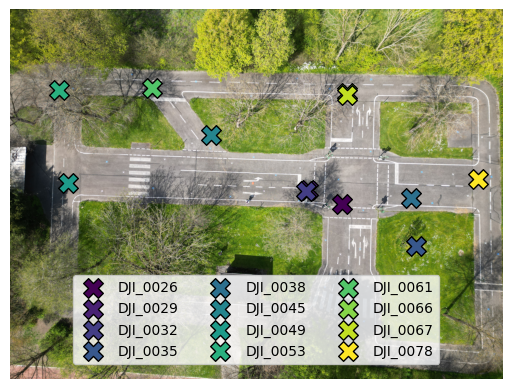

In [147]:
import matplotlib.cm as cm
plt.imshow(img_tv)

norm = plt.Normalize(min(colors), max(colors))
# Use a colormap (e.g., viridis, plasma, etc.)
colormap = plt.colormaps.get_cmap('viridis')

# Plot each point individually with its corresponding label
for i in range(len(positions)):
    color = colormap(norm(colors[i]))
    plt.scatter(positions[i, 0], positions[i, 1], color=color, label=labels[i], marker='X', s=200,
               edgecolors='black')

# Create legend with unique labels
handles, unique_labels = plt.gca().get_legend_handles_labels()
unique_labels, unique_handles = zip(*dict(zip(unique_labels, handles)).items())
plt.legend(unique_handles, unique_labels)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.3),
          ncol=3, fancybox=True, shadow=False, framealpha=0.8)
plt.axis('off')

plt.show()

In [148]:
# Die Hoehe ist ja nun -500px unter der Kamera in X meter hoehe.

In [158]:
heights = -positions[:, -1] / SCALING_FACTOR
heights

array([10.07963727,  9.98357661, 10.15311185, 10.19206847, 10.00555131,
        2.78321154, 10.4852342 ,  2.84121707, 10.01564044,  8.01165016,
        7.88798093, 10.254574  ])

In [178]:
for name, height in zip(labels, heights):
    print(f'{name}: {height:.2f}m')

DJI_0026: 10.08m
DJI_0029: 9.98m
DJI_0032: 10.15m
DJI_0035: 10.19m
DJI_0038: 10.01m
DJI_0045: 2.78m
DJI_0049: 10.49m
DJI_0053: 2.84m
DJI_0061: 10.02m
DJI_0066: 8.01m
DJI_0067: 7.89m
DJI_0078: 10.25m


### Rotations

In [208]:
pv_img = 'DJI_0038'
tv_img = 'DJI_0017'
reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv = load_dataset(pv_img, tv_img)
img_pv, img_tv = get_images(pv_img, tv_img)

reference_pts_pv_arr, reference_pts_tv_arr, validation_pts_pv_arr, validation_pts_tv_arr = transform_points(
    reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv)
reference_pts_pv_arr = reference_pts_pv_arr[:,:2].astype(np.float32)
reference_pts_tv_arr = reference_pts_tv_arr[:,:2].astype(np.float32) 

image_points = reference_pts_pv_arr
object_points = reference_pts_tv_arr
object_points = np.pad(
    object_points, 
    ((0, 0), (0, 1)), 
    mode = 'constant', 
    constant_values = 0
)

retval, rvec, tvec = cv2.solvePnP(
    object_points, 
    image_points, 
    K,
    dist
)
rotM = cv2.Rodrigues(rvec)[0]
camera_position = np.matmul(-rotM.T, tvec) 

In [209]:
from scipy.spatial.transform import Rotation as R

# Create a Rotation object from the rotation matrix
rotation = R.from_matrix(rotM)

# Convert the rotation to Euler angles (assuming 'zyx' order)
euler_angles = rotation.as_euler('zyx', degrees=True)

# Extract the individual angles
yaw, pitch, roll = euler_angles

print(f"Yaw: {yaw} degrees")
print(f"Pitch: {pitch} degrees")
print(f"Roll: {roll+90} degrees")

Yaw: 71.88340921793711 degrees
Pitch: 0.42323541356962907 degrees
Roll: 35.999871935046194 degrees


In [206]:
# I think roll is actually pitch

In [212]:
def get_camera_rotation(pv_img, tv_img='DJI_0017'):
    reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv = load_dataset(pv_img, tv_img)
    img_pv, img_tv = get_images(pv_img, tv_img)

    reference_pts_pv_arr, reference_pts_tv_arr, validation_pts_pv_arr, validation_pts_tv_arr = transform_points(
        reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv)
    reference_pts_pv_arr = reference_pts_pv_arr[:,:2].astype(np.float32)
    reference_pts_tv_arr = reference_pts_tv_arr[:,:2].astype(np.float32) 

    image_points = reference_pts_pv_arr
    object_points = reference_pts_tv_arr
    object_points = np.pad(
        object_points, 
        ((0, 0), (0, 1)), 
        mode = 'constant', 
        constant_values = 0
    )
    
    retval, rvec, tvec = cv2.solvePnP(
        object_points, 
        image_points, 
        K,
        dist
    )
    rotM = cv2.Rodrigues(rvec)[0]
    camera_position = np.matmul(-rotM.T, tvec) 

    rotation = R.from_matrix(rotM)
    
    # Convert the rotation to Euler angles (assuming 'zyx' order)
    euler_angles = rotation.as_euler('zyx', degrees=True)
    
    # Extract the individual angles
    yaw, pitch, roll = euler_angles
    return roll+90
rot_0026 = get_camera_rotation('DJI_0026')
rot_0029 = get_camera_rotation('DJI_0029')
rot_0032 = get_camera_rotation('DJI_0032')
rot_0035 = get_camera_rotation('DJI_0035')
rot_0038 = get_camera_rotation('DJI_0038')
rot_0045 = get_camera_rotation('DJI_0045')
rot_0049 = get_camera_rotation('DJI_0049')
rot_0053 = get_camera_rotation('DJI_0053')
rot_0061 = get_camera_rotation('DJI_0061')
rot_0066 = get_camera_rotation('DJI_0066')
rot_0067 = get_camera_rotation('DJI_0067')
rot_0078 = get_camera_rotation('DJI_0078')

In [214]:
rot_0026

40.867392490041524

In [218]:
rotations = [ 
    rot_0026, 
    rot_0029, 
    rot_0032, 
    rot_0035, 
    rot_0038,
    rot_0045,
    rot_0049,
    rot_0053,
    rot_0061,
    rot_0066,
    rot_0067,
    rot_0078
]
for name, rotation in zip(labels, rotations):
    print(f'{name}: {rotation:.2f} deg')

DJI_0026: 40.87 deg
DJI_0029: 40.16 deg
DJI_0032: 41.34 deg
DJI_0035: 41.04 deg
DJI_0038: 36.00 deg
DJI_0045: 25.70 deg
DJI_0049: 36.08 deg
DJI_0053: 29.99 deg
DJI_0061: 41.40 deg
DJI_0066: 36.33 deg
DJI_0067: 44.46 deg
DJI_0078: 34.68 deg


In [305]:
def get_camera_rotation(pv_img, tv_img='DJI_0017'):
    reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv = load_dataset(pv_img, tv_img)
    img_pv, img_tv = get_images(pv_img, tv_img)

    reference_pts_pv_arr, reference_pts_tv_arr, validation_pts_pv_arr, validation_pts_tv_arr = transform_points(
        reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv)
    reference_pts_pv_arr = reference_pts_pv_arr[:,:2].astype(np.float32)
    reference_pts_tv_arr = reference_pts_tv_arr[:,:2].astype(np.float32) 

    image_points = reference_pts_pv_arr
    object_points = reference_pts_tv_arr
    object_points = np.pad(
        object_points, 
        ((0, 0), (0, 1)), 
        mode = 'constant', 
        constant_values = 0
    )
    
    retval, rvec, tvec = cv2.solvePnP(
        object_points, 
        image_points, 
        K,
        dist
    )
    rotM = cv2.Rodrigues(rvec)[0]
    # TODO GET ROTM WRT TO OTHER ROTM !

    # Convert rotation matrix to Euler angles
    r = R.from_matrix(rotM)
    angles = r.as_euler('zyx', degrees=True)
    
    # Add 90 degrees rotation around z-axis
    angles[2] += 90  # Add 90 degrees to the yaw angle
    angles[2] = -angles[2]
    
    # Convert Euler angles back to rotation matrix
    r_modified = R.from_euler('zyx', angles, degrees=True)
    rot_matrix_corrected = r_modified.as_matrix()
    return rot_matrix_corrected
rot_0026 = get_camera_rotation('DJI_0026')
rot_0029 = get_camera_rotation('DJI_0029')
rot_0032 = get_camera_rotation('DJI_0032')
rot_0035 = get_camera_rotation('DJI_0035')
rot_0038 = get_camera_rotation('DJI_0038')
rot_0045 = get_camera_rotation('DJI_0045')
rot_0049 = get_camera_rotation('DJI_0049')
rot_0053 = get_camera_rotation('DJI_0053')
rot_0061 = get_camera_rotation('DJI_0061')
rot_0066 = get_camera_rotation('DJI_0066')
rot_0067 = get_camera_rotation('DJI_0067')
rot_0078 = get_camera_rotation('DJI_0078')

In [306]:
rotations = [
    rot_0026, 
    rot_0029, 
    rot_0032, 
    rot_0035, 
    rot_0038,
    rot_0045,
    rot_0049,
    rot_0053,
    rot_0061,
    rot_0066,
    rot_0067,
    rot_0078
]

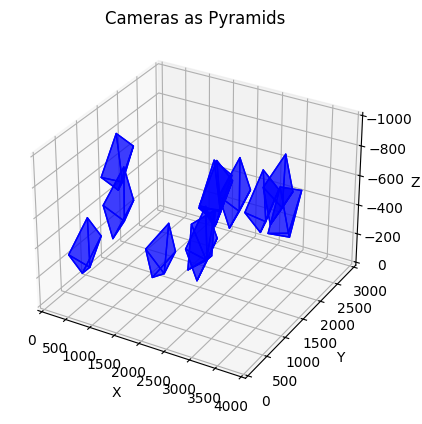

In [307]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_camera(ax, position, rotation_matrix, scale=1):
    # Define camera pyramid vertices (assuming base is a square)
    pyramid_vertices = np.array([[0, 0, 0],
                                  [1, 1, -1],
                                  [1, -1, -1],
                                  [-1, -1, -1],
                                  [-1, 1, -1]], dtype=float)  # Convert to float
    # Scale the pyramid
    pyramid_vertices *= scale
    # Rotate vertices based on rotation matrix
    rotated_vertices = np.dot(pyramid_vertices, rotation_matrix.T) + position
    
    # Define faces of the pyramid
    faces = [[rotated_vertices[0], rotated_vertices[1], rotated_vertices[2]],
             [rotated_vertices[0], rotated_vertices[2], rotated_vertices[3]],
             [rotated_vertices[0], rotated_vertices[3], rotated_vertices[4]],
             [rotated_vertices[0], rotated_vertices[4], rotated_vertices[1]],
             [rotated_vertices[1], rotated_vertices[2], rotated_vertices[3], rotated_vertices[4]]]
    
    # Plot the pyramid
    ax.add_collection3d(Poly3DCollection(faces, color='b', alpha=0.5))

# Example rotation matrix (identity matrix, no rotation)
rotation_matrix = np.eye(3)

# Example camera positions
# camera_positions = np.array([[0, 0, 0],
                             # [2, 2, 2],
                             # [-3, 1, 1]])

camera_positions = positions

# Create figure and axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot cameras
for position, rotation in zip(camera_positions, rotations):
    plot_camera(ax, position, rotation, scale=200)

# Set plot limits and labels
ax.set_xlim([0, 4000])
ax.set_ylim([0, 3000])
ax.set_zlim([0, -1000])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Cameras as Pyramids')

# Show plot
plt.show()